In [2]:
import pandas as pd
import numpy as np

# import file
df = pd.read_csv('../../res/tp2/german_credit.csv', sep=',')

In [3]:
all_attrs = set(df)
all_attrs.remove('Creditability')

continuous_attrs = {'Duration of Credit (month)': ['<= 12', '<= 24', '<= 36', '<= 48', '<= 60', '> 60'],
                    'Credit Amount': ['<= 1000', '<= 2000', '<= 3000', '<= 4000', '<= 5000', '<= 6000', '<= 7000', '<= 8000',
                                      '<= 9000', '<= 10000', '<= 12000', '<= 14000', '> 14000'],
                    'Age (years)': ['< 30', '< 60', '>= 60']}
discrete_attrs = dict(map(lambda attr_name: (attr_name, list(df[attr_name].unique())),
                          filter(lambda attr_name: attr_name not in continuous_attrs, all_attrs)
                         ))
print(all_attrs)

{'Purpose', 'Foreign Worker', 'No of Credits at this Bank', 'Type of apartment', 'Account Balance', 'Instalment per cent', 'Guarantors', 'Age (years)', 'No of dependents', 'Concurrent Credits', 'Sex & Marital Status', 'Duration of Credit (month)', 'Value Savings/Stocks', 'Most valuable available asset', 'Credit Amount', 'Payment Status of Previous Credit', 'Length of current employment', 'Occupation', 'Telephone', 'Duration in Current address'}


In [4]:
from sklearn.model_selection import train_test_split

# Separar los datos en datos de entrenamiento y testeo
train, test = train_test_split(df, test_size=0.2)

test.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
264,1,4,12,2,3,1493,1,2,4,2,...,3,3,34,3,2,1,3,2,1,1
758,0,2,30,2,0,2150,1,3,4,2,...,2,4,24,1,2,1,3,1,1,1
260,1,4,15,2,2,2708,1,2,2,3,...,3,2,27,1,2,2,2,1,1,1
698,1,2,45,4,1,4576,2,1,3,3,...,4,3,27,3,2,1,3,1,1,1
864,0,1,40,4,6,5998,1,3,4,3,...,3,4,27,1,2,1,3,1,2,1


In [5]:
import math

global entropy
entropy = None
positive_creditability = 'Creditability == 1'

def format_query_string(attr, value, index=-1):
    if attr in continuous_attrs:
        return f'not (`{attr}` {continuous_attrs[attr][index-1]}) and `{attr}` {value}' if index > 0 else f'`{attr}` {value}'
    
    return f'`{attr}` == {value}'

def get_entropy_term(p):
    return - p * math.log2(p) if not math.isclose(p, 0) else 0

def get_entropy(data, cond=positive_creditability): # H(S)
    positive_freq = len(data.query(cond)) / len(data) if len(data) != 0 else 0
    negative_freq = 1 - positive_freq if len(data) != 0 else 0
    entropy = get_entropy_term(positive_freq) + get_entropy_term(negative_freq)
    
    return entropy

def get_attr_entropy(data, cond): # H(Sv)
    positive_freq = len(data.query(cond)) / len(data) if len(data) != 0 else 0
    negative_freq = 1 - positive_freq if len(data) != 0 else 0
    return get_entropy_term(positive_freq) + get_entropy_term(negative_freq)

def get_rows_by_attr_cond(data, attr, cond, cond_index):
    rows = None
    
    if cond_index == 0:
        rows = data.query(f'`{attr}` {cond}')
    else:
        prev_cond = continuous_attrs[attr][cond_index-1]
        rows = data.query(f'not(`{attr}` {prev_cond}) and `{attr}` {cond}')
        
    return rows
    
def gain(data, attr, class_cond=positive_creditability):
    ret = get_entropy(data)
    
    if attr in continuous_attrs:
        for i, cond in enumerate(continuous_attrs[attr]):
            rows = get_rows_by_attr_cond(data, attr, cond, i)
            ret -= len(rows) / len(data) * get_attr_entropy(rows, class_cond)
            # print(f'{attr}: {ret}')
    else:
        for value in discrete_attrs[attr]: # TODO FIX: PREGUNTAR SI VALOR DE ATRIBUTO NO APARECE EN TRAIN, FALLA
            rows = data.query(f'`{attr}` == {value}')
            ret -= len(rows) / len(data) * get_attr_entropy(rows, class_cond)
            # print(f'{attr},{value}: {ret}')
    
    return ret

gains = {}
for attr in train.columns:
    if attr == 'Creditability':
        continue
    gains[attr] = gain(train, attr)

print(gains)

#df['Credit Amount'].hist(grid=True, bins=30, rwidth=0.9, color='#607c8e')
#print(get_entropy(train, train.Creditability == 1))

{'Account Balance': 0.08862127981244246, 'Duration of Credit (month)': 0.028793188579503172, 'Payment Status of Previous Credit': 0.06004213880332379, 'Purpose': 0.027436244364967194, 'Credit Amount': 0.036354256546042005, 'Value Savings/Stocks': 0.027486329407942475, 'Length of current employment': 0.012641311492020357, 'Instalment per cent': 0.0038056651684311715, 'Sex & Marital Status': 0.007075880273194848, 'Guarantors': 0.007993307439717143, 'Duration in Current address': 0.0015966080445247444, 'Most valuable available asset': 0.020322041403205787, 'Age (years)': 0.015764568675499073, 'Concurrent Credits': 0.010020079410330555, 'Type of apartment': 0.019795034796773137, 'No of Credits at this Bank': 0.004359273156403404, 'Occupation': 0.002423772065229479, 'No of dependents': 5.568241955325459e-05, 'Telephone': 0.0011248815601295203, 'Foreign Worker': 0.006970084769016435}


In [11]:
from tree import Tree, NodeType

def get_max_gain(gains):
    max_attr = None
    max_gain = -1
    for attr, gain in gains.items():
        if gain > max_gain:
            max_gain = gain
            max_attr = attr
    return max_attr, max_gain

used_attrs = set({})

def add_level(data, current_level_attr, node=None, max_depth=None, stdout=False):
    global used_attrs
    
    if max_depth is not None:
        max_depth -= 1
    
    tree = None
    current_level_attr_node = None
    if node is None:
        tree = Tree()
        tree.root = current_level_attr_node = Tree.Node(NodeType.attr, current_level_attr)
    else:
        current_level_attr_node = node.add_child(NodeType.attr, current_level_attr)
    
    used_attrs.add(current_level_attr)
    
    values = continuous_attrs[current_level_attr] if current_level_attr in continuous_attrs else discrete_attrs[current_level_attr]
    for i, val in enumerate(values):
        
        if tree is not None and stdout:
            print(f'Processing value {val} for root attribute {tree.root.value}...')
        
        current_level_attr_value_node = current_level_attr_node.add_child(NodeType.val, val)
        rows = data.query(format_query_string(current_level_attr, val, i))
        
        # There are no rows matching all the branches' conditions, so we get the most frequent Creditability value
        # of the parent matching rows
        if (len(rows) == 0):
            current_level_attr_value_node.add_child(NodeType.leaf, data['Creditability'].mode()[0])
            continue
        
        classes = rows['Creditability'].unique()
        
        # Only positive or negative examples left (leaf)
        if len(classes) == 1:
            current_level_attr_value_node.add_child(NodeType.leaf, classes[0])
            continue
        else:
            selected_attrs = set(data) - set(['Creditability'])
            unprocessed_attrs = selected_attrs - used_attrs # Selected dataset columns - Used columns
            if len(unprocessed_attrs) == 0 or (max_depth is not None and max_depth <= 0):  # No more attributes to calculate gain for (leaf)
                current_level_attr_value_node.add_child(NodeType.leaf, rows['Creditability'].mode()[0])  # The most frequent value for Creditability
            else:
                current_gains = {}
                for attr in unprocessed_attrs:
                    current_gains[attr] = gain(rows, attr)
                next_level_attr, _ = get_max_gain(current_gains)
                # print(current_gains)
                if (next_level_attr is None):
                    raise Exception(f'Invalid state: gains returned attribute None - {current_gains}')
                else:
                    add_level(rows, next_level_attr, current_level_attr_value_node, max_depth)
    
    used_attrs.remove(current_level_attr)
    
    if tree:
        used_attrs.clear()
        return tree


#tr = Tree(root_attr)
#add_level(train, root_attr, tr.root)
#print('\n\n\n\n\n**********************************\n\n\n')
#print(tr)

In [13]:
def evaluate_condition(attr, asked_value, tree_cond): # attr = Age, asked_value = 28, tree_cond = '<= 30'
    if attr in continuous_attrs:
        index = continuous_attrs[attr].index(tree_cond)
        return eval(f'not ({asked_value} {continuous_attrs[attr][index-1]}) and {asked_value} {tree_cond}' if index > 0 else f'{asked_value} {tree_cond}')
        
    return asked_value == tree_cond


def classify(row, tree, stdout=False):
    """Given a row, navigate through the tree according to the constraints set by the row.
    """
    
    current_node = tree.root
    current_node_type = NodeType.attr
    
    while(current_node.children):
        current_node_val = current_node.value
        current_node_type = current_node.node_type
        if stdout:
            print(f'Node value: {current_node_val} - Type: {current_node_type}')
        
        if current_node_type == NodeType.attr:
            row_val = row[current_node_val]
            found_value = False
            for child in current_node.children:
                # print(f'Attr {current_node_val} Child Value: {child.value}')
                if evaluate_condition(current_node_val, row_val, child.value):
                    current_node = child
                    found_value = True
                    break
            if not found_value:
                raise Exception('Could not find attribute value')
        elif current_node_type == NodeType.val:
            current_node = current_node.children[0]
        else:
            raise Exception('Invalid State')
    
    if stdout:
        print(f'\nNode value: {current_node.value} - Type: {current_node.node_type}\n')
    return current_node.value


def build_tree(data, max_depth=None, stdout=False):
    root_gains = {}
    for attr in list(data):
        if attr == 'Creditability':
            continue
        root_gains[attr] = gain(data, attr)
    
    root_attr, _ = get_max_gain(root_gains)
    if (root_attr is None):
        raise Exception(f'Invalid state: gains returned attribute None - {root_gains}')
    
    tree = add_level(data, root_attr, max_depth=max_depth, stdout=stdout)
    if stdout:
        print(tree)
    return tree

# print(test.iloc[0])
# classify(test.iloc[0], tree)

In [14]:
import statistics as stats
from random import sample

def build_forest(data, sample_fraction=0.4, iterations=3, max_depth=None, stdout=False):
    forest = []
    selected_columns = list(data)
    
    # Every iteration builds a different tree
    while iterations > 0:
        print(f'Remaining trees: {iterations}')
            
        subset = data.sample(frac=sample_fraction, replace=True, axis=0)
        t = build_tree(subset, max_depth=max_depth, stdout=stdout)
        forest.append(t)
        iterations -= 1
        
        #print(f'\n\n\n\n\n\n\n\n************STARTING TREE************\n\n\n\n\n\n\n\n{t}')
        
    print('Done\n')
    return forest


def classify_random_forest(row, data=train, forest=None, max_depth=None, stdout=False):
    """Classify row with each tree and return the mode value for the class
    """
    
    if forest is None:
        forest = build_forest(data, max_depth=max_depth, stdout=stdout)
    classifications = []
    for tree in forest:
        classifications.append(classify(row, tree, stdout))
    if stdout:
        print(classifications)
    return stats.mode(classifications)

In [15]:
row = test.iloc[0]
print(row)
print(classify_random_forest(row, stdout=True))

Creditability                           1
Account Balance                         4
Duration of Credit (month)             12
Payment Status of Previous Credit       2
Purpose                                 3
Credit Amount                        1493
Value Savings/Stocks                    1
Length of current employment            2
Instalment per cent                     4
Sex & Marital Status                    2
Guarantors                              1
Duration in Current address             3
Most valuable available asset           3
Age (years)                            34
Concurrent Credits                      3
Type of apartment                       2
No of Credits at this Bank              1
Occupation                              3
No of dependents                        2
Telephone                               1
Foreign Worker                          1
Name: 264, dtype: int64
Remaining trees: 3
Processing value 1 for root attribute Account Balance...
Processing value 2

<AxesSubplot:>

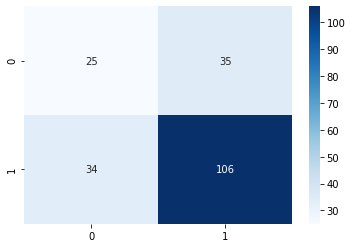

In [16]:
import seaborn as sns

id3_confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in id3_confusion_matrix.keys():
    columns.append(key)
    id3_confusion_matrix[key] = { 0: 0, 1: 0 } # {0: {0: 700, 1: 1048}, 1: {...}}

tree = build_tree(train)
for i in range(len(test)):
    row = test.iloc[i]
    creditability = row['Creditability']
    
    result = classify(row, tree=tree)
    id3_confusion_matrix[creditability][result] += 1

id3_confusion_df = { key : list(id3_confusion_matrix[key].values()) for key in id3_confusion_matrix.keys() }
id3_confusion_df = pd.DataFrame.from_dict(id3_confusion_df, orient='index', columns=columns)

sns.heatmap(id3_confusion_df, annot=True, cmap='Blues', fmt='g')

Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done



<AxesSubplot:>

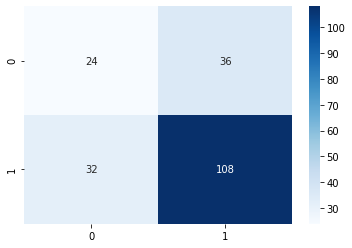

In [17]:
# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 } # {0: {0: 700, 1: 1048}, 1: {...}}

forest = build_forest(train, sample_fraction=0.6, iterations=9)
for i in range(len(test)):
    row = test.iloc[i]
    creditability = row['Creditability']
    
    result = classify_random_forest(row, forest=forest)
    confusion_matrix[creditability][result] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')

In [18]:
print(test['Creditability'].value_counts())

1    140
0     60
Name: Creditability, dtype: int64


In [19]:
def get_precision_plot_id3(train_data, test_data, depth_range, stdout=False):
    plot_points = []
    for i in depth_range:
        if stdout:
            print(f'Generating results using {i} as depth limit...')
            
        tree = build_tree(train_data, max_depth=i, stdout=False)
        
        correct_classifications = 0
        for index, row in test_data.iterrows():
            classification = classify(row, tree=tree)
            if classification == row['Creditability']:
                correct_classifications += 1
        
        plot_points.append(correct_classifications / len(test_data))
    
    if stdout:
        print(plot_points)
    
    return plot_points

In [20]:
column_count = len(all_attrs)
attr_range = range(3, column_count + 1, 1)
id3_test_precisions = get_precision_plot_id3(train, test, attr_range, True)
id3_train_precisions = get_precision_plot_id3(train, train, attr_range, True)

Generating results using 3 as depth limit...
Generating results using 4 as depth limit...
Generating results using 5 as depth limit...
Generating results using 6 as depth limit...
Generating results using 7 as depth limit...
Generating results using 8 as depth limit...
Generating results using 9 as depth limit...
Generating results using 10 as depth limit...
Generating results using 11 as depth limit...
Generating results using 12 as depth limit...
Generating results using 13 as depth limit...
Generating results using 14 as depth limit...
Generating results using 15 as depth limit...
Generating results using 16 as depth limit...
Generating results using 17 as depth limit...
Generating results using 18 as depth limit...
Generating results using 19 as depth limit...
Generating results using 20 as depth limit...
[0.705, 0.615, 0.67, 0.66, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655, 0.655]
Generating results using 3 as depth limit...
Generatin

Text(0, 0.5, 'Precisión')

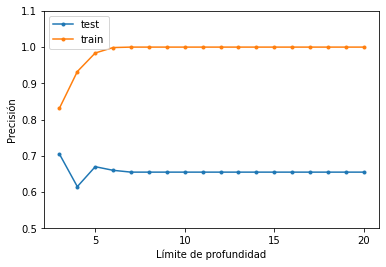

In [25]:
# Using ID3
id3_plot = pd.DataFrame({'test': id3_test_precisions, 'train': id3_train_precisions}, index=[i for i in attr_range])
id3_lines = id3_plot.plot(style='.-')
id3_lines.locator_params(integer=True)
id3_lines.set_ylim(0.5, 1.1)
id3_lines.set_xlabel('Límite de profundidad')
id3_lines.set_ylabel('Precisión')

In [22]:
def get_precision_plot_forest(train_data, test_data, depth_range, iterations=3, stdout=False):    
    plot_points = []
    
    for i in depth_range:
        if stdout:
            print(f'Generating results using {i} as depth limit...')
            
        forest = build_forest(train_data, max_depth=i, iterations=iterations, stdout=False)
        
        correct_classifications = 0
        for index, row in test_data.iterrows():
            classification = classify_random_forest(row, forest=forest)
            if classification == row['Creditability']:
                correct_classifications += 1
        
        plot_points.append(correct_classifications / len(test_data))
    
    if stdout:
        print(plot_points)
    
    return plot_points

In [23]:
column_count = len(all_attrs)
attr_range = range(3, column_count + 1, 1)
test_precisions = get_precision_plot_forest(train, test, attr_range, stdout=True)
train_precisions = get_precision_plot_forest(train, train, attr_range, stdout=True)

Generating results using 3 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 4 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 5 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 6 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 7 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 8 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 9 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 10 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 11 as depth limit...
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 1

Text(0, 0.5, 'Precisión')

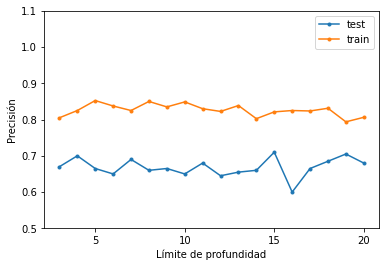

In [26]:
# Using Random Forest with 3 iterations
forest_plot = pd.DataFrame({'test': test_precisions, 'train': train_precisions}, index=[i for i in attr_range])
# forest_lines = forest_plot.plot.line()
# df = pd.DataFrame({'test': [0.65, 0.705, 0.655, 0.715, 0.67, 0.625, 0.62, 0.665, 0.67, 0.645, 0.625, 0.665, 0.66, 0.715, 0.685, 0.655, 0.675, 0.675], 'train': [0.7225, 0.76, 0.74625, 0.75375, 0.79, 0.81125, 0.79375, 0.8425, 0.82125, 0.84125, 0.83375, 0.815, 0.84125, 0.82625, 0.82875, 0.84, 0.8425, 0.81625]}, index=[i for i in attr_range])
forest_lines = forest_plot.plot(style='.-')
forest_lines.locator_params(integer=True)
forest_lines.set_ylim(0.5, 1.1)
forest_lines.set_xlabel('Límite de profundidad')
forest_lines.set_ylabel('Precisión')

In [27]:
column_count = len(all_attrs)
attr_range = range(3, column_count + 1, 1)
test_precisions_2 = get_precision_plot_forest(train, test, attr_range, iterations=9, stdout=True)
train_precisions_2 = get_precision_plot_forest(train, train, attr_range, iterations=9, stdout=True)

Generating results using 3 as depth limit...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 4 as depth limit...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 5 as depth limit...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 6 as depth limit...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 7 as depth limit...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining 

Text(0, 0.5, 'Precisión')

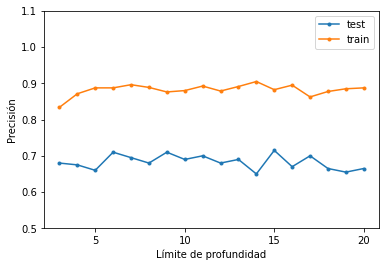

In [28]:
# Using Random Forest with 9 iterations
forest_plot_2 = pd.DataFrame({'test': test_precisions_2, 'train': train_precisions_2}, index=[i for i in attr_range])
forest_lines_2 = forest_plot_2.plot(style='.-')
forest_lines_2.locator_params(integer=True)
forest_lines_2.set_ylim(0.5, 1.1)
forest_lines_2.set_xlabel('Límite de profundidad')
forest_lines_2.set_ylabel('Precisión')